In [2]:
#---------------------------------- IMPORTING!! ---------------------------------- 

%matplotlib notebook
import rebound
import numpy as np
import sys
from IPython.display import display, clear_output
from math import sqrt, log10, sin, cos
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [3]:
#---------------------------------- INTEGRATING!! ---------------------------------- 

Nstars = 2

# All distances in A.U.
mh = 4.0e6
mb = 3.76e9/mh
md = 6.0e10/mh
mha = 1.0e12/mh
ab = 2.0e7
rh = 4.125e9
ad = 5.7e8
bd = 6.2e7
scale = 1.6e9

# Galaxy potential taken from http://adsabs.harvard.edu/abs/2014ApJ...793..122K,
# only using bulge + disk for now (need to add halo!).
# Note: There is a typo in that paper where "a_d" is said to be 2750 kpc, it should be 2.75 kpc.

def migrationAccel(reb_sim):
    r = sqrt(ps[1].x**2+ps[1].y**2+ps[1].z**2)
    rho2 = ps[1].x**2+ps[1].y**2
    zbd = sqrt(ps[1].z**2+bd**2)
    logterm = r/rh - (r**2)/(2*rh**2)
    logterm = np.log(1.0+(r/rh))
    rterm = (r+rh)*(r**2)
    ps[1].ax += -mb*ps[1].x/(r*(ab+r)**2) - md*ps[1].x/(rho2+(ad+zbd)**2)**1.5 #+ mha*ps[1].x*((logterm/r**3)-(1.0/rterm))
    ps[1].ay += -mb*ps[1].y/(r*(ab+r)**2) - md*ps[1].y/(rho2+(ad+zbd)**2)**1.5 #+ mha*ps[1].y*((logterm/r**3)-(1.0/rterm))
    ps[1].az += -mb*ps[1].z/(r*(ab+r)**2) - md*ps[1].z*(ad+zbd)/(zbd*(rho2+(ad+zbd)**2)**1.5) #+ mha*ps[1].z*((logterm/r**3)-(1.0/rterm))
    #print mha*ps[1].x*((logterm/r**3)-(1.0/rterm))
    
t_start = 0
t_end = 10000

Nout = 100

#nfrag = rnd.randint(100, 300)
nfrag = 20

posx = [[[] for y in range(nfrag)] for x in range(Nstars)]
posy = [[[] for y in range(nfrag)] for x in range(Nstars)]
posz = [[[] for y in range(nfrag)] for x in range(Nstars)]
        
for star in tqdm(range(Nstars)):
    # Randomly drawn mass of star disrupted, fraction of star mass lost in disruption, 
    # number of fragments, and initial 3D angle of outgoing stellar debris

    m_star = rnd.uniform(1,4) #between 1 and 4 solar masses
    percentage_lost = rnd.random()
    m_deb = m_star*percentage_lost
    m_frag = m_deb/nfrag

    # Velocities are set to be just a little bit hyperbolic.
    vels = [sqrt(2.0 + 9.0e-5*(0.5 + float(x)/float(nfrag))) for x in range(nfrag)]
    for i, vel in enumerate(vels):
        # Set up simulation
        sim = rebound.Simulation()
        sim.integrator = "ias15"
        sim.add(m=1.0)
        angle = rnd.uniform(0., 2.*np.pi)
        sim.add(m=0.0,x=0.0,y=sin(angle),z=cos(angle),vx=vel,vy=0.0,vz=0.0)
        sim.N_active = 1
        sim.additional_forces = migrationAccel

        ps = sim.particles

        times = np.linspace(0.0, 20.0*((ab)**(1.5)/sqrt(mb))*2.*np.pi, Nout)
        for ti, time in enumerate(times):
            #print(time)
            sim.integrate(time, exact_finish_time=1)
            posx[star][i].append(ps[1].x/scale)
            posy[star][i].append(ps[1].y/scale)
            posz[star][i].append(ps[1].z/scale)
    
    t_start += 10000
    t_end += 10000

# f = open('plotdata.txt', 'w')
# col_width = max(len(val) for row in data for val in row) + 2  # padding

# for star in range(Nstars):
#     f.write('***Star index: ' + star + '***\n')
#     for i in range(nfrag):
#         f.write('Fragment: ' + i + '\n')
#     f.write('--------------------------------------------------------')
        

100%|██████████| 2/2 [00:18<00:00,  9.04s/it]


In [ ]:
#---------------------------------- PLOTTING!! ---------------------------------- 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = sns.color_palette("hls", Nstars).as_hex()
for star in range(Nstars):
    for i in range(nfrag):
        ax.plot(posx[star][i],posy[star][i],posz[star][i], c = colors[star]);
        ax.scatter([posx[star][i][-1]],[posy[star][i][-1]],[posz[star][i][-1]],c = colors[star]);

<IPython.core.display.Javascript object>


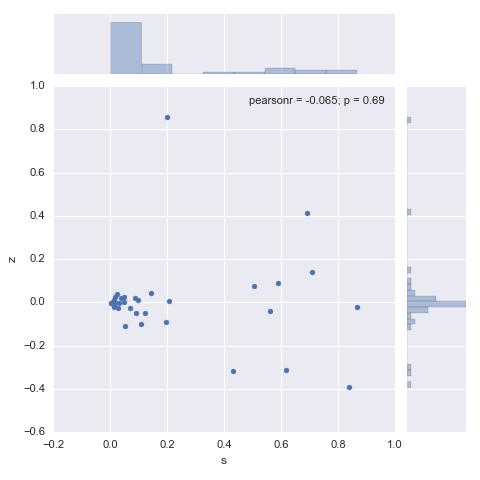

<IPython.core.display.Javascript object>


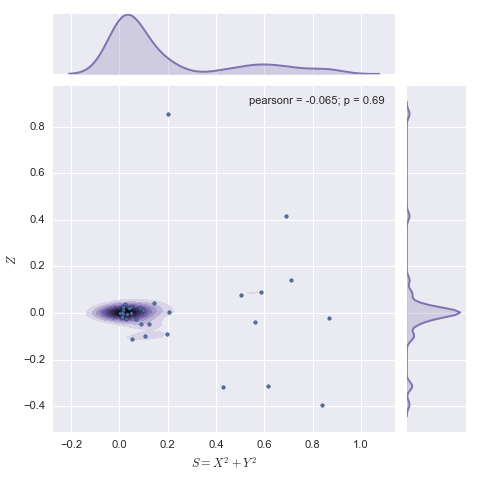

In [11]:
#---------------------------------- VISUALIZING!! ---------------------------------- 
data = []
for star in range(Nstars):
    for i in range(nfrag):
        end = len(posx[star][i])
        point = [sqrt(posx[star][i][end - 1]**2 + posy[star][i][end - 1]**2), posz[star][i][end - 1]]
        data.append(point)
        
fragdata = np.array([point for point in data])
df = pd.DataFrame(fragdata, columns=["s", "z"])

#Scatter plots
sns.jointplot(x="s", y="z", data=df);

#Density plots
# sns.jointplot(x="x", y="y", data=df, kind="kde");
g = sns.jointplot(x="s", y="z", data=df, kind="kde", color="m")
g.plot_joint(plt.scatter, c="b", s=10, marker="o")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$S = X^2 + Y^2$", "$Z$");

In [ ]:
#---------------------------------- EXAMPLES!! ---------------------------------- 

# It can also be useful to visualize a bivariate distribution of two variables. 
# The easiest way to do this in seaborn is to just the jointplot() function, which 
# creates a multi-panel figure that shows both the bivariate (or joint) relationship 
# between two variables along with the univariate (or marginal) distribution of each on separate axes.

mean, cov = [0, 1], [(1, .5), (.5, 1)]
data = np.random.multivariate_normal(mean, cov, 100)
print data
df = pd.DataFrame(data, columns=["x", "y"])

# # The most familiar way to visualize a bivariate distribution is a scatterplot, where each observation 
# # is shown with point at the x and y values. This is analgous to a rug plot on two dimensions. 
# # You can draw a scatterplot with the matplotlib plt.scatter function, and it is also the default kind 
# # of plot shown by the jointplot() function:

sns.jointplot(x="x", y="y", data=df, kind="kde");

# # You can also draw a two-dimensional kernel density plot with the kdeplot() function. 
# # This allows you to draw this kind of plot onto a specific (and possibly already existing) 
# # matplotlib axes, whereas the jointplot() function manages its own figure:

f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(df.x, df.y, ax=ax)
sns.rugplot(df.x, color="g", ax=ax)
sns.rugplot(df.y, vertical=True, ax=ax);

# The jointplot() function uses a JointGrid to manage the figure. 
# For more flexibility, you may want to draw your figure by using JointGrid directly. 
# jointplot() returns the JointGrid object after plotting, which you can use to add more layers 
# or to tweak other aspects of the visualization:

g = sns.jointplot(x="x", y="y", data=df, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");